In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [3]:
plt.style.use("ggplot")

In [4]:
df = pd.read_excel("data/real_estate2.xlsx")

In [5]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [6]:
df["elapsed"] = 2018 - df["year"]

In [7]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [8]:
dis_arr = df["distance"].unique()

In [9]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [10]:
dis_dict = {dis_arr[0]:10,dis_arr[1]:15,dis_arr[2]:5,dis_arr[3]:20,dis_arr[4]:30,dis_arr[5]:np.nan}

In [11]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [12]:
df["distance2"] = df["distance"].apply(lambda x:dis_dict[x])

In [13]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [14]:
df = df.dropna()

In [15]:
df2 = df[["space","elapsed","distance2","value"]]

In [16]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


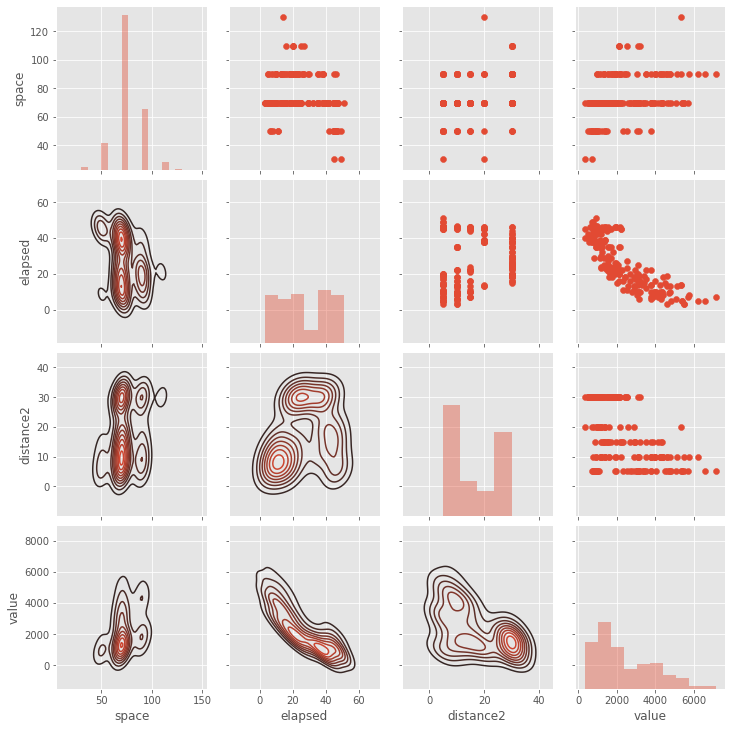

In [17]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [18]:
stan_model = """
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d;
  real s;
  real e;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma);
  }
}
"""

In [19]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5 NOW.
C:\Users\NDA04\Anaconda3\envs\pystan\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\NDA04\AppData\Local\Temp\tmp4y5ca5gt\stanfit4anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5_6820672402245860059.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [21]:
stan_data = {"N":df.shape[0],"elapsed":df["elapsed"],"dis":df["distance2"],"space":df["space"],"Y":df["value"]}

In [22]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=4,seed=123)

In [23]:
fit

Inference for Stan model: anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.56    0.08   5.06 -67.66 -60.94 -57.46 -54.19 -47.76   3562    1.0
s      24.62    0.07   3.57  17.45  22.19  24.56  27.02  31.49   2467    1.0
e     -67.67    0.07   3.68 -74.87 -70.16 -67.69 -65.17 -60.57   3012    1.0
b     3299.3    5.91  293.6 2720.4 3102.2 3305.6 3494.3 3890.0   2467    1.0
sigma  636.5    0.48  31.54 577.84 614.95 634.98 656.55 700.83   4383    1.0
lp__   -1363    0.03   1.56  -1367  -1364  -1363  -1362  -1361   2414    1.0

Samples were drawn using NUTS at Thu May 28 15:40:06 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

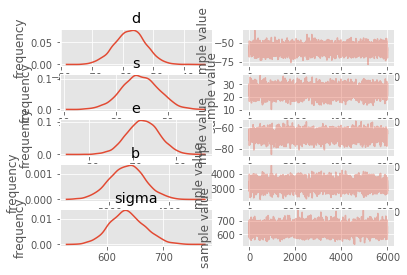

In [24]:
fig = fit.plot()